# Stochastic LSTM with MMD loss in PyTorch
We want to be able to model a timeseries such that we can produce samples from it. Conventionally, an LSTM maybe trained with a mean square loss or variational loss. These assume a form of the density for the output - albeit flexible. We want to be able to produce an implicit model of the density of timeseries. To train with such a timeseries, we want to be able to sample from it and use a loss to check if the actual input is produced from the same probability distribution as the output. 


## Using MMD as a loss function
To use MMD as a loss function, we need 
1. A generating process parametrized the parameters \theta
2. Samples from the true generating process 

To fit the parameters, we assume an initial value of the parameters $\theta_0$. Then, we will produce M samples from $y \sim p_{\theta_0}$. Assuming we have N input samples, we will calculate the MMD loss function

$MMD(x, y) = \frac{1}{N(N-1)}\sum_{i=1}^N \sum_{j\neq i}^N k(x_i, x_j) + \frac{1}{M(M-1)}\sum_{i=1}^M \sum_{j\neq i}^M k(y_i, y_j) - \frac{2}{NM}\sum_{i=1}^N \sum_{j=1}^M k(x_i, y_j)$

## Using Autograd for fitting parameters
We can use the autograd feature of PyTorch to differentiate the parameters $\theta$ of the probability distribution. 
?? Do we generate new noise samples for every iteration of the optimization or no? If we use the same noise, it could overfit to the particular samples generated.

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.parameter import Parameter

import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

## Defining the MMD Loss Function

In [2]:
from torch.nn.modules.loss import _assert_no_grad
from torch.autograd import Function

def rbf_kernel_matrix(x, y):
    '''Calculates the L2 distance between the vectors x (N x D) and y (M x D). Returns
    matrix of size N x M '''
    product = torch.mm(x, torch.transpose(y, 0, 1))
    sum_squares = torch.sum(torch.pow(x, 2), 1).expand_as(product) + torch.transpose(torch.sum(torch.pow(y, 2), 1), 0, 1).expand_as(product)
    return sum_squares-2*product

class MMDLossFn(Function): 
    '''The backward fucntion has not been implemented yet because all the operations are performed used valid torch functions 
    which allows backward to be computed across the graph. To make it faster, we could custom implement the backward function'''
    def __init__(self, sigma):
        super(MMDLossFn, self).__init__()
        self.sigma = sigma
        
    def forward(self, input, gen_samples):
        '''Calculate the unbiased MMD Loss with \sigma as a free parameter'''
        N = input.size(0)
        M = gen_samples.size(0)
        k_xx = rbf_kernel_matrix(input, input)
        k_yy = rbf_kernel_matrix(gen_samples, gen_samples)
        k_xy = rbf_kernel_matrix(input, gen_samples)
        if N==1:
            MMD = 0
        else:
            MMD = 1.0/(N*(N-1))*(torch.sum(torch.exp(-k_xx/self.sigma**2))-torch.sum(torch.exp(-torch.diag(k_xx)/self.sigma**2)))
        if M==1:
            MMD += 0
        else:
            MMD += 1.0/(M*(M-1))*(torch.sum(torch.exp(-k_yy/self.sigma**2))-torch.sum(torch.exp(-torch.diag(k_yy)/self.sigma**2)))
        MMD += -2.0/(N*M)*torch.sum(torch.exp(-k_xy/self.sigma**2))
        return MMD

class MMDLoss(nn.Module):
    def __init__(self, sigma):
        '''Instantiate the class with kernel width parameter for the RBF kernel '''
        super(MMDLoss, self).__init__()
        self.sigma = sigma
    
    def forward(self, inputs, samples):
        '''Return the MMD loss function'''
        _assert_no_grad(samples)
        backend_fn = MMDLossFn(self.sigma)
        #backend_fn = getattr(self._backend, type(self).__name__)
        return backend_fn(input, samples)

## Analysis of the MMD loss landscape

### Samples from 2 one-dimensional Gaussians with different means with different sample sizes 
We create 10 different samples pairs and plot the MMD Loss

Observations:
1. High variance for lower values of M_vals
2. Increasing the kernel bandwidth smoothens out the curve - need to check effect with different values of 

In [ ]:
no_trials = 50
sample_1 = torch.Tensor(no_trials, 1, 1)
M_vals = [10, 20, 50, 100, 1000]
mean_vals = torch.from_numpy(np.arange(-10, 10, 0.1).astype(np.dtype('float32')))
empirical_mean = torch.Tensor(len(M_vals), no_trials)
MMD_1D_constantvar = torch.Tensor(len(M_vals), len(mean_vals), no_trials)
MMDfn = MMDLossFn(1)
for n in range(no_trials):
    print n
    for i in range(len(M_vals)):
        sample_1[n] = torch.randn(1, 1)
        empirical_mean[i, n] = torch.mean(sample_1)
        sample_2 = torch.randn(M_vals[i], 1)
        for j in range(len(mean_vals)):
            MMD_1D_constantvar[i, j, n] = MMDfn.forward(Variable(sample_1[n]), Variable(mean_vals[j:j+1].expand(M_vals[i], 1)+sample_2)).data[0]
print('Empirical standard deviation is ', torch.mean(sample_1))        

In [ ]:
color = ['r', 'g', 'b', 'k', 'y']
for i in range(len(M_vals)):
    plt.plot(mean_vals.numpy(), np.sum(MMD_1D_constantvar[i,:,:].numpy(), axis = 1)/no_trials, alpha=1.0, color = color[i])
#plt.plot(sig_vals, np.sum(MMD_1D_constantmean[i,:,:].numpy(), axis = 1)/no_trials, alpha=0.2, color = color[i])
plt.show()

In [ ]:
MMD_1D_constantvar_full = torch.Tensor(len(M_vals), len(mean_vals))
for i in range(len(M_vals)):
    sample_2 = torch.randn(M_vals[i], 1)
    for j in range(len(mean_vals)):
        MMD_1D_constantvar_full[i, j] = MMDfn.forward(Variable(torch.squeeze(sample_1, 2)), Variable(mean_vals[j:j+1].expand(M_vals[i], 1)+sample_2)).data[0]

In [ ]:
color = ['r', 'g', 'b', 'k', 'y']
for i in range(len(M_vals)):
    plt.plot(mean_vals.numpy(), MMD_1D_constantvar_full[i,:].numpy(), alpha=1.0, color = color[i])
    plt.plot(mean_vals.numpy(), np.sum(MMD_1D_constantvar[i,:,:].numpy(), axis = 1)/no_trials, alpha=1.0, color = color[i], linestyle='--')
#plt.plot(sig_vals, np.sum(MMD_1D_constantmean[i,:,:].numpy(), axis = 1)/no_trials, alpha=0.2, color = color[i])
plt.show()

### Samples from 2 one-dimensional Gaussians with different variances with different sample sizes 
Since we have only one sample there is no point to calculating the empirical std.

In [ ]:
no_trials = 50
sample_1 = torch.Tensor(no_trials, 1, 1)
M_vals = [10, 20, 50, 100, 1000]
sig_vals = np.arange(0, 10, 0.5)
MMD_1D_constantmean = torch.Tensor(len(M_vals), len(sig_vals), no_trials)
MMDfn = MMDLossFn(1)
for n in range(no_trials):
    print n
    for i in range(len(M_vals)):
        sample_1[n] = torch.randn(1, 1)
        sample_2 = torch.randn(M_vals[i], 1)
        for j in range(len(sig_vals)):
            MMD_1D_constantmean[i, j, n] = MMDfn.forward(Variable(sample_1[n]), Variable(torch.mul(sample_2, sig_vals[j]))).data[0]
print('Empirical standard deviation is ', torch.std(sample_1))

In [ ]:
color = ['r', 'g', 'b', 'k', 'y']
for i in range(len(M_vals)):
    plt.plot(np.sum(MMD_1D_constantmean[i,:,:].numpy(), axis = 1)/no_trials, alpha=1.0, color = color[i])
#plt.plot(sig_vals, np.sum(MMD_1D_constantmean[i,:,:].numpy(), axis = 1)/no_trials, alpha=0.2, color = color[i])
plt.show()

In [ ]:
MMD_1D_constantmean_full = torch.Tensor(len(M_vals), len(sig_vals))
for i in range(len(M_vals)):
    sample_2 = torch.randn(M_vals[i], 1)
    for j in range(len(sig_vals)):
        MMD_1D_constantmean_full[i, j] = MMDfn.forward(Variable(torch.squeeze(sample_1, 2)), Variable(torch.mul(sample_2, sig_vals[j]))).data[0]

In [ ]:
MMD_1D_constantmean_full

In [ ]:
color = ['r', 'g', 'b', 'k', 'y']
for i in range(len(M_vals)):
    plt.plot(sig_vals, MMD_1D_constantmean_full[i,:].numpy(), alpha=1.0, color = color[i])
    plt.plot(sig_vals, np.sum(MMD_1D_constantmean[i,:,:].numpy(), axis = 1)/no_trials, alpha=1.0, color = color[i], linestyle='--')
#plt.plot(sig_vals, np.sum(MMD_1D_constantmean[i,:,:].numpy(), axis = 1)/no_trials, alpha=0.2, color = color[i])
plt.show()

## -----------------------------------------------------------------------------------------------

## Testing MMD on a bi-modal distribution
As a simple toy example, we first check if the MMD loss is useful in fitting the parameters for a simple bi-modal dsitribution. 

### Loading the data
We use gaussian mixture model with two components as the bi-modal distribution to be sampled from

In [ ]:
import hickle as hkl
filename = '/home/ybansal/Documents/Research/stochastic-prednet/Data/xor.hkl'
file = open(filename, 'r')
data = hkl.load(file)
#data = hkl.load(file)
file.close()
plt.plot(data[:,0], data[:,1], 'o')
plt.show()

### Transforming a unit-Gaussian 
1. Sample for a 2-D unit Gaussian
2. Transform the 2-D Gaussian using a neural network (here we use a fully-connected neural network 40 x 40 x 2). This gives us the samples from the generating distribution.
3. Calculate the MMD loss and differentiate

I need to check:
1. Effect of N and M
2. Effect of constant vs variable noise
3. Effect of optimizer
4. Effect of neural network size


### Constant noise
Here, we assume some noise vector with M samples produced from a 2D Gaussian are given to the neural network as an input

#### Defining the model

In [142]:
class TwoLayerNet(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(TwoLayerNet, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)
        
    def forward(self, x):
        h_relu = self.linear1(x).clamp(min=0)
        gen_samples = self.linear2(h_relu)
        return gen_samples
    
class TwoLayerNoiseNet(nn.Module):
    def __init__(self, M, D_in, H, D_out):
        super(TwoLayerNet, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)
        
    def forward(self):
        self.x = Variable(torch.randn(M, D_in), requires_grad=False)
        h_relu = self.linear1(x).clamp(min=0)
        gen_samples = self.linear2(h_relu)
        return gen_samples
    

    
class ThreeLayerNet(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super(ThreeLayerNet, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)
        
    def forward(self, x):
        h1_relu = self.linear1(x).clamp(min=0)
        h2_relu = self.linear2(h1_relu).clamp(min=0)
        gen_samples = self.linear3(h2_relu)
        return gen_samples
    
class ThreeLayerNoiseNet(nn.Module):
    def __init__(self, M, D_in, H1, H2, D_out):
        super(ThreeLayerNoiseNet, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)
        
    def forward(self):
        self.x = Variable(torch.randn(M, D_in), requires_grad=False)
        h1_relu = self.linear1(self.x).clamp(min=0)
        h2_relu = self.linear2(h1_relu).clamp(min=0)
        gen_samples = self.linear3(h2_relu)
        return gen_samples
    
class ScaleLoc(nn.Module):
    def __init__(self, D):
        super(ScaleLoc, self).__init__()
        self.mean = Parameter(torch.randn(D))
        self.sigma = Parameter(torch.randn(D, D))
        
    def forward(self, x):
        return self.mean.expand_as(x) + x.mm(self.sigma)
        

In [ ]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, M, D_in, H1, H2, D_out = 100, 100, 2, 200, 100, 2

# Create random Tensors to hold inputs and outputs, and wrap them in Variables
x = Variable(torch.randn(M, D_in), requires_grad=False)
mean = torch.Tensor([6, 6])
sigma = torch.Tensor([[1, 0], [0, 1]])
y = Variable(mean.expand(M, D_in) + torch.randn(M, D_in), requires_grad=False)
#y = Variable(torch.from_numpy(data[:N].astype(np.dtype('float32'))), requires_grad=False)

# Construct our model by instantiating the class defined above
#model = TwoLayerNet(D_in, H1, D_out)
#model = ThreeLayerNet(D_in, H1, H2, D_out)
model = ScaleLoc(2)

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
#criterion = MMDLossFn(sigma=1.0)
criterion = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)
for t in range(10000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    #loss = criterion.forward(y_pred, y)
    loss = criterion(y_pred, y)
    print(t, loss.data[0])

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
# for m in model.parameters():
#     print(m.data)
plt.plot(y[:,0].data.numpy(), y[:,1].data.numpy(), 'bo', label='Input Data')
plt.plot(y_pred[:,0].data.numpy(), y_pred[:,1].data.numpy(), 'ro', label='Transformed Samples')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
#plt.savefig('/home/ybansal/Documents/Research/stochastic-prednet/Figures/Bimodal_Adam_lr_001.png')
plt.show()

In [ ]:
x_test = Variable(torch.randn(1000, D_in), requires_grad=False)
learned_samples = model(x_test)
plt.plot(learned_samples.data[:,0].numpy(), learned_samples.data[:,1].numpy(), 'o', label='New Samples')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
#plt.savefig('/home/ybansal/Documents/Research/stochastic-prednet/Figures/Bimodal_Adam_lr_001_samples.png')
plt.show()

## Testing MMD on image data

Instead of a simple bimodal distribution we give it images of a square ball in 2 different locations 

1. Some samples are very clear while some still have Gaussian noise
2. Some samples have a dark spot where the other ball is supposed to be. What is causing this?
3. 2 dimensional PCA for different noise vs constant noise looks different. For the first case, it is a straight line (trained once) and for the second case there were two very clear clusters (trained once). The PCA for the original data is very clearly bimodal

### Creating the data

In [3]:
def make_square_ball(x, y, im_rows=20, im_cols=20, width=3, height=3, noise_sig=0.1):

    T = x.shape[0]
    vid = np.zeros((T, im_rows, im_cols), dtype=np.dtype(float))
    for t in range(T):
        vid[t, y[t]:y[t]+height, x[t]:x[t]+width] = 1.
        vid[t, :, :] += npr.normal(0, noise_sig, (im_rows, im_cols))
    return vid

/home/ybansal/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


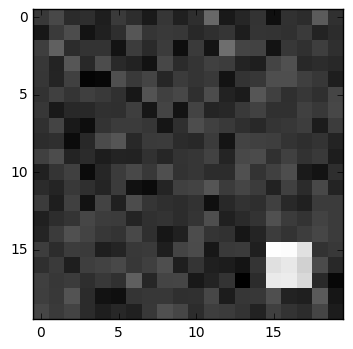

In [15]:
n_per_position = 200
positions = [(5, 5), (15, 15)]
no_pos = len(positions)
im_rows = 20
im_cols = 20
img_data = np.zeros((n_per_position*no_pos, im_rows, im_cols), dtype=np.dtype(float))
for pos_ind in range(no_pos):
    x = positions[pos_ind][0]*np.ones(n_per_position)
    y = positions[pos_ind][1]*np.ones(n_per_position)
    img_data[pos_ind*n_per_position:(pos_ind+1)*n_per_position] = make_square_ball(x, y, im_rows=im_rows, im_cols=im_cols, noise_sig=0.1)
plt.imshow(img_data[200], interpolation='None')
plt.gray()
plt.show()

npr.shuffle(img_data)

In [224]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, M, D_in, H1, H2, D_out = 400, 100, 20, 2000, 1000, 400

# Create random Tensors to hold inputs and outputs, and wrap them in Variables
x = Variable(torch.randn(M, D_in), requires_grad=False)
# mean = torch.Tensor([6, 6])
# sigma = torch.Tensor([[1, 0], [0, 1]])
# y = Variable(mean.expand(M, D_in) + torch.randn(M, D_in), requires_grad=False)
y = Variable(torch.from_numpy(img_data[:N].reshape((N, im_rows*im_cols)).astype(np.dtype('float32'))), requires_grad=False)

# Construct our model by instantiating the class defined above
#model = TwoLayerNet(D_in, H1, D_out)
model = ThreeLayerNet(D_in, H1, H2, D_out)
#model = ScaleLoc(2)

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
criterion = MMDLossFn(sigma=5)
#criterion = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for t in range(10000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion.forward(y_pred, y)
    #loss = criterion(y_pred, y)
    print(t, loss.data[0])

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

(0, 0.39438164234161377)
(1, 0.6799913048744202)
(2, 0.1981428861618042)
(3, 0.13813984394073486)
(4, 0.14942479133605957)
(5, 0.14724385738372803)
(6, 0.12136399745941162)
(7, 0.09097862243652344)
(8, 0.06933128833770752)
(9, 0.05786263942718506)
(10, 0.051917314529418945)
(11, 0.049414753913879395)
(12, 0.04782295227050781)
(13, 0.046799659729003906)
(14, 0.046718716621398926)
(15, 0.0466686487197876)
(16, 0.045522451400756836)
(17, 0.043436527252197266)
(18, 0.041341543197631836)
(19, 0.03981614112854004)
(20, 0.03871363401412964)
(21, 0.03777623176574707)
(22, 0.0370405912399292)
(23, 0.03662109375)
(24, 0.03641033172607422)
(25, 0.0361785888671875)
(26, 0.03582024574279785)
(27, 0.03542459011077881)
(28, 0.03510761260986328)
(29, 0.034850478172302246)
(30, 0.03454482555389404)
(31, 0.03417527675628662)
(32, 0.033835649490356445)
(33, 0.03358781337738037)
(34, 0.03339076042175293)
(35, 0.03316915035247803)
(36, 0.03289663791656494)
(37, 0.032607078552246094)
(38, 0.0323449373245239

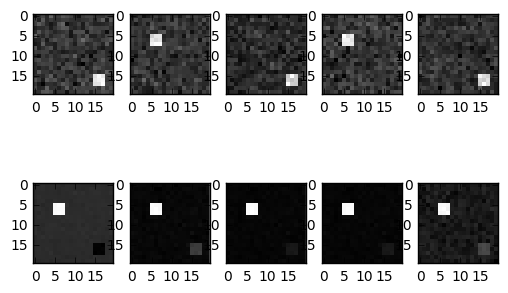

In [206]:
y_ind = npr.choice(400, 5)
y_pred_ind = npr.choice(100, 5)
num_plots = 5
for i in range(num_plots):
    plt.subplot(2, num_plots, i+1)
    plt.imshow(y[y_ind[i]].data.numpy().reshape((20, 20)), interpolation='None')
    plt.gray()
    
    plt.subplot(2, num_plots, (i+1)+num_plots)
    plt.imshow(y_pred[y_pred_ind[i]].data.numpy().reshape((20, 20)), interpolation='None')
    plt.gray()
#plt.savefig('/home/ybansal/Documents/Research/stochastic-prednet/Figures/BallRandomPosMMD_more.png')
plt.show()
    

### Checking PCA of generated outputs

In [219]:
from sklearn.decomposition import PCA

y_pred = model()
pca = PCA(n_components = 1)
pca.fit(y.data.numpy())
y_reduced = pca.transform(y.data.numpy())

In [ ]:
#plt.plot(y_reduced[:,0], y_reduced[:,1], 'bo')
plt.plot(y_reduced[:,0], 'bo')
plt.show()

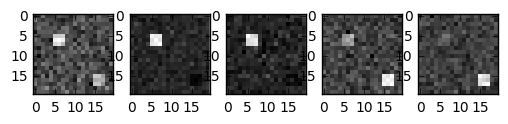

In [103]:
x_test = Variable(torch.randn(5, D_in), requires_grad=False)
learned_sample = model(x_test)
for i in range(num_plots):
    plt.subplot(2, num_plots, i+1)
    plt.imshow(learned_sample[i].data.numpy().reshape((20, 20)), interpolation='None')
    plt.gray()
plt.show()

### MSE on the same data

In [104]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, M, D_in, H1, H2, D_out = 400, 1, 20, 2000, 1000, 400

# Create random Tensors to hold inputs and outputs, and wrap them in Variables
x = Variable(torch.randn(M, D_in), requires_grad=False)
# mean = torch.Tensor([6, 6])
# sigma = torch.Tensor([[1, 0], [0, 1]])
# y = Variable(mean.expand(M, D_in) + torch.randn(M, D_in), requires_grad=False)
y = Variable(torch.from_numpy(img_data[:N].reshape((N, im_rows*im_cols)).astype(np.dtype('float32'))), requires_grad=False)

# Construct our model by instantiating the class defined above
#model = TwoLayerNet(D_in, H1, D_out)
model = ThreeLayerNet(D_in, H1, H2, D_out)
#model = ScaleLoc(2)

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
criterion = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for t in range(10000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred.expand_as(y), y)
    print(t, loss.data[0])

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

(0, 6224.0966796875)
(1, 7627.1494140625)
(2, 4273.47705078125)
(3, 4014.02490234375)
(4, 4051.030029296875)
(5, 3956.37109375)
(6, 3863.57666015625)
(7, 3803.708251953125)
(8, 3731.474365234375)
(9, 3645.146728515625)
(10, 3574.7666015625)
(11, 3531.86474609375)
(12, 3503.190185546875)
(13, 3481.575439453125)
(14, 3467.0107421875)
(15, 3458.737548828125)
(16, 3451.68994140625)
(17, 3447.58251953125)
(18, 3444.520263671875)
(19, 3438.843505859375)
(20, 3433.50048828125)
(21, 3430.58544921875)
(22, 3426.9765625)
(23, 3422.28173828125)
(24, 3418.50244140625)
(25, 3415.124267578125)
(26, 3412.53271484375)
(27, 3410.534912109375)
(28, 3407.44970703125)
(29, 3404.896484375)
(30, 3403.3818359375)
(31, 3401.84814453125)
(32, 3400.87890625)
(33, 3400.265380859375)
(34, 3399.31640625)
(35, 3398.926025390625)
(36, 3398.895751953125)
(37, 3398.615478515625)
(38, 3398.433837890625)
(39, 3397.740478515625)
(40, 3397.1123046875)
(41, 3396.71533203125)
(42, 3396.096923828125)
(43, 3395.812255859375)


KeyboardInterrupt: 

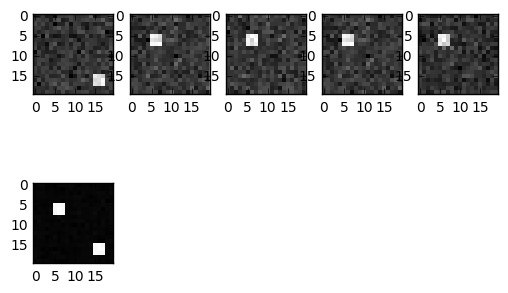

In [106]:
y_ind = npr.choice(400, 5)
y_pred_ind = npr.choice(400, 5)
num_plots = 5
for i in range(num_plots):
    plt.subplot(2, num_plots, i+1)
    plt.imshow(y[y_ind[i]].data.numpy().reshape((20, 20)), interpolation='None')
    plt.gray()
    
plt.subplot(2, num_plots, num_plots+1)
plt.imshow(y_pred[0].data.numpy().reshape((20, 20)), interpolation='None')
plt.gray()
plt.savefig('/home/ybansal/Documents/Research/stochastic-prednet/Figures/BallRandomPosMSE.png')
plt.show()

### Sampling from the neural net with different noise examples
Here, we assume some noise vector with M samples produced from a 2D Gaussian are generated by the network itself - so they will be different for every forward iteration

## Comparison to GAN

## Comparison to VAE

## ---------------------------------------------------------------------------------------------

## Testing MMD on timeseries data
Now, we want to check how this loss function performs when we have multiple timesteps

Need to check 
1. If all frames should be concatenated or evaluated individually (So, N = N*T and M = M*T)
2. With MMD, how would we condition on anything - in GAN, we feed the conditional variable as an input to the discriminator but for MMD we don't really have any such option. We need to think about how we will write a conditional version for this
3. Batch-size variation

We need to design some good test data to make sure it can learn the timeseries.

## Comparison to conditional GAN for timeseries

## Comparison to STORN, Deep Kalman and/or VRNN

## ---------------------------------------------------------------------------------------------------
# Scratch

In [ ]:
x1 = torch.randn(100, 2)
mean = torch.randn(2)

In [ ]:
mean = mean.expand_as(x1)

In [ ]:
sigma = torch.ones(2,2)
x1.mm(sigma)

In [ ]:
tmp1 = Variable(torch.Tensor([[1, 1], [2,2]]), requires_grad=True)
tmp2 = Variable(torch.Tensor([[3, 3], [4,4]]), requires_grad=True)
tmp1, tmp2

In [ ]:
mmdfn = MMDLossFn(1)
tmp3 = mmdfn.forward(tmp1, tmp2)
tmp3.backward()

In [ ]:
tmp1.grad